Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive


<ipython-input-3-99866bf70d63>:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Weather predictions in F'].fillna(df['Weather predictions in F'].mean(), inplace=True)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0 Loss: 0.09759274
Epoch 25 Loss: 0.00002510
Epoch 50 Loss: 0.00003559
Epoch 75 Loss: 0.00068443


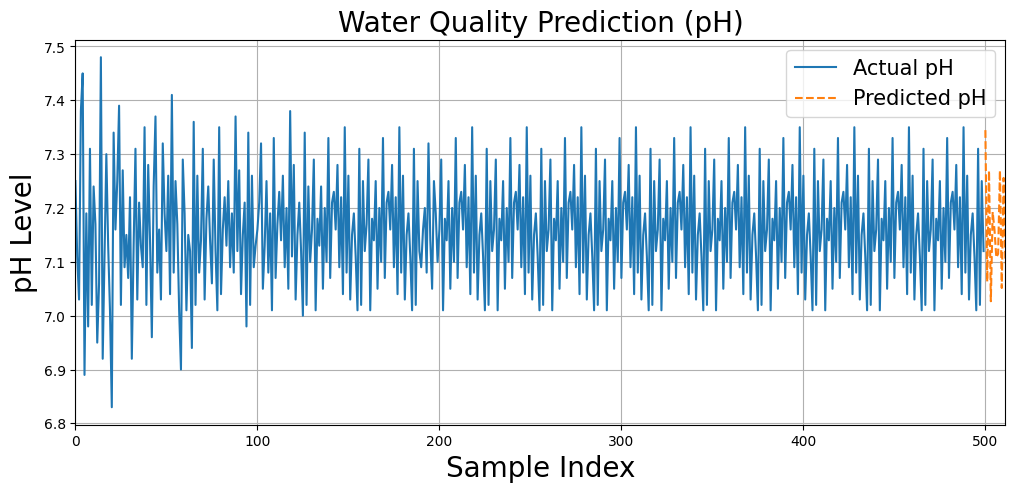

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import torch
from torch import nn
from sklearn.preprocessing import MinMaxScaler

# Mount Google Drive and load new CSV
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/

# Load the new dataset
df = pd.read_csv('Water Quality Testing w forecast.csv')

# Display the first 20 rows
cm = sns.light_palette("green", as_cmap=True)
df.head(20).style.background_gradient(cmap=cm)

# Handle missing values in "Weather predictions in F"
df['Weather predictions in F'].fillna(df['Weather predictions in F'].mean(), inplace=True)

# Selecting features for model
features = ['pH', 'Temperature (°C)', 'Turbidity (NTU)', 'Dissolved Oxygen (mg/L)',
            'Conductivity (µS/cm)', 'Weather predictions in F', 'Wind Speed (m/s)',
            'Atmospheric Pressure (hPa)']

# Feature scaling
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_features = scaler.fit_transform(df[features].values)

# Define training and testing data
test_data_size = 12
train_data = scaled_features[:-test_data_size]
test_data = scaled_features[-test_data_size:]

# Convert to PyTorch tensors
train_data = torch.FloatTensor(train_data)
test_data = torch.FloatTensor(test_data)

# Define sequence window
train_window = 12

def create_inout_sequences(input_data, window):
    inout_seq = []
    L = len(input_data)
    for i in range(L - window):
        train_seq = input_data[i:i + window]
        train_label = input_data[i + window, 0]  # Predicting the "pH" column (index 0)
        inout_seq.append((train_seq, train_label))
    return inout_seq

train_inout_seq = create_inout_sequences(train_data, train_window)

# Define the LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_layer_size=128, num_layers=2, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers=num_layers)
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        lstm_out, _ = self.lstm(input_seq.view(len(input_seq), 1, -1))
        predictions = self.linear(lstm_out[:, -1, :])
        return predictions[-1]

# Initialize the model
input_size = len(features)  # Number of input features
model = LSTM(input_size=input_size)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training the model
epochs = 100
for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        y_pred = model(seq)
        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i % 25 == 0:
        print(f'Epoch {i} Loss: {single_loss.item():.8f}')

# Predictions
# Predictions
model.eval()
fut_pred = 12
test_inputs = train_data[-train_window:].clone()  # Clone the last window of training data as a tensor

for i in range(fut_pred):
    seq = test_inputs[-train_window:]  # Extract the last `train_window` entries
    seq = seq.view(-1, len(features))  # Ensure the sequence is in the correct shape
    with torch.no_grad():
        prediction = model(seq).item()  # Get the prediction
    # Add the prediction as a new row with other features as zeros
    new_row = torch.zeros(len(features))
    new_row[0] = prediction  # Only update the `pH` value (index 0)
    test_inputs = torch.cat((test_inputs, new_row.unsqueeze(0)), dim=0)

# Inverse transform predictions for "pH"
actual_predictions = scaler.inverse_transform(test_inputs[-fut_pred:].numpy())[:, 0]

# Visualization
x = np.arange(len(df['pH']), len(df['pH']) + fut_pred, 1)
plt.figure(figsize=(12, 5))
plt.title('Water Quality Prediction (pH)', fontsize=20)
plt.ylabel('pH Level', fontsize=20)
plt.xlabel('Sample Index', fontsize=20)
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(df['pH'], label="Actual pH")
plt.plot(x, actual_predictions, label="Predicted pH", linestyle="--")
plt.legend(fontsize=15)
plt.show()

